In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

In [5]:
# Based on https://link.springer.com/chapter/10.1007/978-3-642-40846-5_16 

# Calculate h(y, Yi)
def h(y, Yi):
    return 1 if y in Yi else 0

# Calculate IRperLabel for each label y
def calculate_IRperLabel(all_labels, df):
    IR = {}
    # Split tags into lists of labels
    df['label_list'] = df['tags'].apply(lambda x: x.split())
    for y in all_labels:
        label_counts = [sum(h(y, Yi) for Yi in df['label_list'])]
        majority_label_count = sum(label_counts)
        
        # Get the number of labels in the dataset
        IR[y] = majority_label_count / len(df) if len(df) > 0 else 0

    return IR

# Calculate MeanIR (average imbalance ratio)
def calculate_MeanIR(IR):
    return np.mean(list(IR.values()))

# Calculate CVIR (coefficient of variation of imbalance ratio)
def calculate_CVIR(IR, MeanIR):
    mean_squared_diff = np.mean([(val - MeanIR)**2 for val in IR.values()])
    return np.sqrt(mean_squared_diff) / MeanIR if MeanIR != 0 else 0

def plot_spread(data):
    # Flatten the list of labels
    all_tags = data['tags'].apply(lambda x: x.split() if isinstance(x, str) else x)
    flattened_tags = [tag for sublist in all_tags for tag in sublist]

    # Convert to a DataFrame for easy handling
    tag_df = pd.DataFrame(flattened_tags, columns=['tag'])

    # Sort tags alphabetically
    sorted_tag_counts = tag_df['tag'].value_counts().sort_index()  # Sort alphabetically by tag
    sorted_tag_df = pd.DataFrame({'tag': sorted_tag_counts.index, 'count': sorted_tag_counts.values})

    # Plot the distribution horizontally
    plt.figure(figsize=(12, 6))  # Increase figure size to accommodate labels
    sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data

    # Add labels and title
    plt.title('Tag Distribution in Multi-Tag Dataset', fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Tags', fontsize=14)

    # Adjust label sizes and positioning
    plt.tight_layout()

    # Display the plot
    plt.show()

def get_std_dev(data):
    tag_counts = Counter(tag for tags in data['tags'] for tag in tags)
    frequencies = list(tag_counts.values())
    imbalance_std = np.std(frequencies)
    print(f"Standard Deviation of Tag Frequencies: {imbalance_std}")


In [6]:
df = pd.read_csv("data/planet\planet/train_classes.csv") # Adjust as needed
df
all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)
print(all_tags)
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))

{'selective_logging', 'agriculture', 'haze', 'cloudy', 'blooming', 'bare_ground', 'habitation', 'water', 'clear', 'road', 'conventional_mine', 'primary', 'slash_burn', 'artisinal_mine', 'blow_down', 'partly_cloudy', 'cultivation'}
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17


In [6]:
# Create validation group before anything happens
train, val = train_test_split(df, test_size=0.1)
print(train.shape)
print(val.shape)

(36431, 2)
(4048, 2)


C:\Users\xxpur\AppData\Local\Temp\ipykernel_14172\3777277896.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


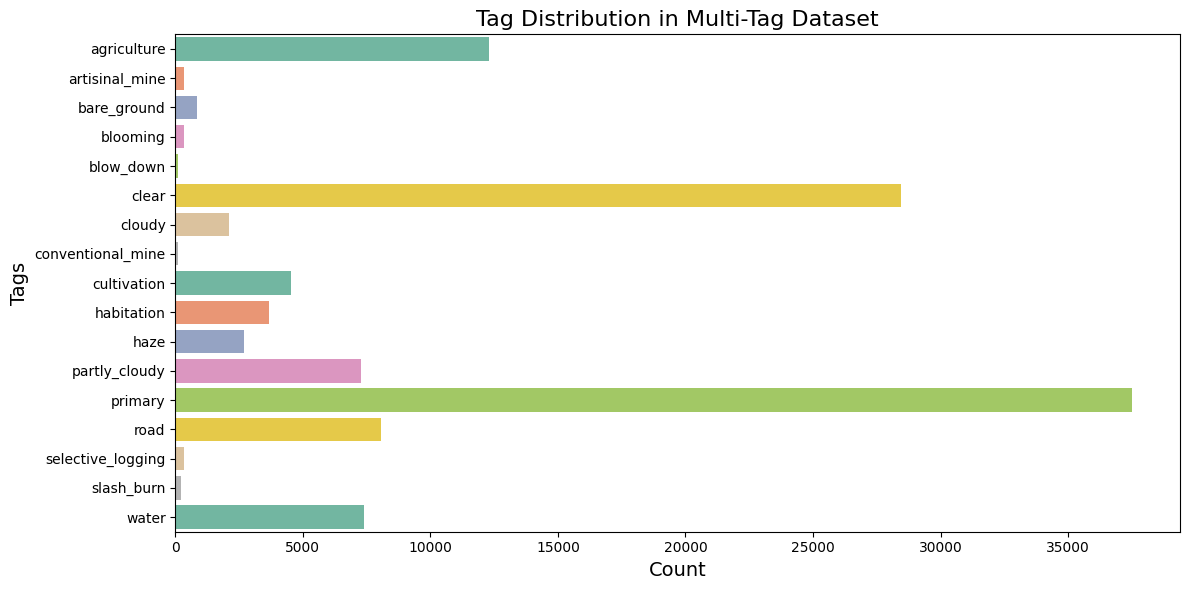

Standard Deviation of Tag Frequencies: 37670.58183190001
IRperLabel: {'primary': 0.9267274389189456, 'agriculture': 0.3042318239086934, 'cultivation': 0.11060055831418761, 'road': 0.1993873366436918, 'habitation': 0.090417253390647, 'partly_cloudy': 0.1793769608933027, 'selective_logging': 0.008399416981644803, 'slash_burn': 0.005163171026952247, 'blooming': 0.00820178364090022, 'bare_ground': 0.021294992465228885, 'clear': 0.702364188838657, 'cloudy': 0.05160700610192939, 'artisinal_mine': 0.00837471281405173, 'conventional_mine': 0.002470416759307295, 'water': 0.18308258603226366, 'blow_down': 0.0024210084241211493, 'haze': 0.06662713999851776}
MeanIR: 0.16886751736194366
CVIR: 1.5019480501275149


In [7]:
plot_spread(df)
get_std_dev(df)
IR = calculate_IRperLabel(all_tags, df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

# Import other dataframes

In [6]:
LP_undersampled_df = pd.read_csv("LP_undersampled_df.csv")
#LP_oversampled_df = pd.read_csv("LP_oversampled_df.csv") # Not in github due to large size, download from google drive
ML_undersampled_df = pd.read_csv("ML_undersampled_df.csv")
ML_oversampled_duplicate_df = pd.read_csv("ML_oversampled_duplicate_df.csv")
ML_oversampled_augment_df = pd.read_csv("ML_oversampled_augment_df.csv") # Must download zip file from google drive, and put into same directory as data
REMEDIAL_modified_df = pd.read_csv("REMEDIAL_modified_df.csv")

In [6]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # if type(csv_file) != str:
        #     self.df = csv_file
        # else:
        #     self.df = pd.read_csv(csv_file)
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        if "aug" in img_name:
            img_path = os.path.join("data/augmented_images/", f"{img_name}.jpg")
            #img_path = os.path.join(self.img_dir, f"{img_name}")
        else:
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        tags = self.df.iloc[idx, 1].split()
        
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

# Train

In [8]:
# Choose which dataframe to use
df_to_load = ML_oversampled_augment_df

In [9]:
# ResNet & DenseNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# EfficientNet_b1
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(240),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [10]:
dataset = MultiLabelImageDataset(df_to_load, img_dir="data/planet\planet/train-jpg", transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
# Since valiation split already done above with original data so no need

# # Only quick testing
#train_idx_small = train_idx[:1000]  # First 1000 training samples
#test_idx_small = test_idx[:200]  # First 200 testing samples

#train_idx_small = train_idx[:32787] 
#test_idx_small = test_idx[:3644] 

#train_dataset = Subset(dataset, train_idx_small)
#test_dataset = Subset(dataset, test_idx_small)
train_dataset = Subset(dataset, list(range(len(df_to_load))))
val_dataset = MultiLabelImageDataset(val, img_dir="data/planet\planet/train-jpg", transform=transform)
val_dataset = Subset(val_dataset, list(range(len(val))))

#train_dataset = Subset(dataset, train_idx)
#test_dataset = Subset(dataset, test_idx)

print(len(train_idx))
print(len(test_idx))



batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

65575
7287


In [11]:
import torchvision.models as models
from torch import nn

num_classes = 17

def ResNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.resnet50(weights='DEFAULT')
    num_ftrs = model_ft.fc.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

def EfficientNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.efficientnet_b1(weights='DEFAULT')
    # num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(1280, num_classes)
    return model_ft

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = ResNetClassifier(num_classes)
#model = EfficientNetClassifier(num_classes)
model.to(device)
#model

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
def train_loop(dataloader, val_dataloader, model, loss_fn, threshold, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 64 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        #if batch % 640 == 0:
        #    val_loop(val_dataloader, model, loss_fn, threshold)

# Not used for modified dataframes
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    test_loss /= num_batches
    f2 /= num_batches
    
    print(f"Test Error: \n f2 score: {f2:.5f}, avg loss: {test_loss:>8f} \n")
    return f2, test_loss

def val_loop(dataloader, model, loss_fn, threshold):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > threshold #0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    val_loss /= num_batches
    f2 /= num_batches
    
    print(f"Val Error: \n f2 score: {f2:.5f}, avg loss: {val_loss:>8f} \n")
    return f2, val_loss


In [14]:
learning_rate = 1e-4 #0.00001
epochs = 5
threshold = 0.24

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
all_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, val_dataloader, model, loss_fn, threshold, optimizer)
    #f2, test_loss = test_loop(test_dataloader, model, loss_fn)
    val_loop(val_dataloader, model, loss_fn, threshold)
    #all_loss.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.070964  [    8/72862]
loss: 0.030416  [  520/72862]
loss: 0.053199  [ 1032/72862]
loss: 0.021889  [ 1544/72862]
loss: 0.038598  [ 2056/72862]
loss: 0.082356  [ 2568/72862]
loss: 0.074700  [ 3080/72862]
loss: 0.044594  [ 3592/72862]
loss: 0.082390  [ 4104/72862]
loss: 0.071959  [ 4616/72862]
loss: 0.091090  [ 5128/72862]
loss: 0.052278  [ 5640/72862]
loss: 0.021935  [ 6152/72862]
loss: 0.021013  [ 6664/72862]
loss: 0.035655  [ 7176/72862]
loss: 0.042371  [ 7688/72862]
loss: 0.051877  [ 8200/72862]
loss: 0.045169  [ 8712/72862]
loss: 0.045517  [ 9224/72862]
loss: 0.046683  [ 9736/72862]
loss: 0.106988  [10248/72862]
loss: 0.015864  [10760/72862]
loss: 0.033910  [11272/72862]
loss: 0.033920  [11784/72862]
loss: 0.047482  [12296/72862]
loss: 0.001995  [12808/72862]
loss: 0.038150  [13320/72862]
loss: 0.032966  [13832/72862]
loss: 0.099912  [14344/72862]
loss: 0.017613  [14856/72862]
loss: 0.021547  [15368/72862]
loss: 0.036941  [15880/72862]


In [37]:
val_loop(val_dataloader, model, loss_fn, 0.15)

Val Error: 
 f2 score: 0.94003, avg loss: 0.062715 



(0.9400317165878752, 0.06271543505688092)

# Export Models

In [32]:
torch.save(model.state_dict(), "ML_oversampled_augmented_ResNet50_5epochs_1e-4_ADAM.pth")

In [43]:
test = EfficientNetClassifier(17)
test.to(device)
test.load_state_dict(torch.load("ML_oversampled_augmented_EfficientNet_6epochs_1e-6_ADAM.pth"))

C:\Users\xxpur\AppData\Local\Temp\ipykernel_21796\4038198945.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test.load_state_dict(torch.load("ML_oversampled_augmented_Ef

<All keys matched successfully>

In [48]:
val_loop(val_dataloader, test, loss_fn, threshold)

Val Error: 
 f2 score: 0.85489, avg loss: 0.145703 



(0.8548881505461942, 0.14570284957294408)

# Other things

In [15]:
class TestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # if type(csv_file) != str:
        #     self.df = csv_file
        # else:
        #     self.df = pd.read_csv(csv_file)
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        if "aug" in img_name:
            img_path = os.path.join("data/augmented_images/", f"{img_name}.jpg")
            #img_path = os.path.join(self.img_dir, f"{img_name}")
        else:
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')


        if self.transform:
            image = self.transform(image)
        
        tags = self.df.iloc[idx, 1].split()
        
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

In [31]:
batch_size = 8
test_dataset = TestDataset(df_to_load, img_dir="data/planet\planet/train-jpg", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
for batch, (X, y) in enumerate(test_dataloader):
    pass

tensor([[[[-0.5938, -0.6623, -0.7650,  ..., -0.6109, -0.5938, -0.5767],
          [-0.6452, -0.6965, -0.7650,  ..., -0.6623, -0.6452, -0.6281],
          [-0.7137, -0.7308, -0.7479,  ..., -0.6965, -0.6965, -0.6965],
          ...,
          [-0.6965, -0.7308, -0.7308,  ..., -0.6281, -0.6281, -0.6452],
          [-0.6452, -0.6794, -0.6623,  ..., -0.6623, -0.6452, -0.6109],
          [-0.6109, -0.6452, -0.6623,  ..., -0.7137, -0.6794, -0.6109]],

         [[-0.3025, -0.3725, -0.4776,  ..., -0.2850, -0.2675, -0.2500],
          [-0.3550, -0.4076, -0.4776,  ..., -0.3375, -0.3200, -0.2675],
          [-0.4251, -0.4426, -0.4601,  ..., -0.3725, -0.3725, -0.3375],
          ...,
          [-0.4076, -0.4251, -0.4076,  ..., -0.3025, -0.3025, -0.3200],
          [-0.3550, -0.3725, -0.3550,  ..., -0.3375, -0.3200, -0.2850],
          [-0.2850, -0.3375, -0.3550,  ..., -0.3901, -0.3550, -0.2850]],

         [[-0.2707, -0.3404, -0.4450,  ..., -0.2707, -0.2532, -0.2010],
          [-0.3230, -0.3753, -

KeyboardInterrupt: 

In [8]:
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
import os

# Function to load raw pixels using PyTorch and PIL
def load_raw_pixels(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure RGB format
    transform = transforms.ToTensor()  # Convert image to a PyTorch tensor
    tensor = transform(image)  # Shape: [C, H, W]
    return tensor

# Define the directory containing the images
image_dir = "data/planet\planet/train-jpg"  # Replace with your actual directory

# Generate full image paths
df["image_path"] = df["image_name"].apply(lambda name: os.path.join(image_dir, name)) + ".jpg"

# Process each image to extract raw pixel data
df["raw_pixels"] = df["image_path"].apply(load_raw_pixels)

# Display the DataFrame
print(df.head())


  image_name                                       tags  \
0    train_0                               haze primary   
1    train_1            agriculture clear primary water   
2    train_2                              clear primary   
3    train_3                              clear primary   
4    train_4  agriculture clear habitation primary road   

                                        label_list  \
0                                  [haze, primary]   
1             [agriculture, clear, primary, water]   
2                                 [clear, primary]   
3                                 [clear, primary]   
4  [agriculture, clear, habitation, primary, road]   

                                 image_path  \
0  data/planet\planet/train-jpg\train_0.jpg   
1  data/planet\planet/train-jpg\train_1.jpg   
2  data/planet\planet/train-jpg\train_2.jpg   
3  data/planet\planet/train-jpg\train_3.jpg   
4  data/planet\planet/train-jpg\train_4.jpg   

                                     

In [18]:
import numpy as np

# Save each tensor as an individual array in a .npz file
raw_pixel_arrays = {f"image_{i}": tensor.numpy() for i, tensor in enumerate(df["raw_pixels"])}
np.savez_compressed("raw_pixels.npz", **raw_pixel_arrays)

# import zlib
# import pickle

# # Compress the raw pixel data with zlib
# compressed_data = zlib.compress(pickle.dumps(df["raw_pixels"].tolist()))

# # Save the compressed data to a file
# with open("raw_pixels.zlib", "wb") as f:
#     f.write(compressed_data)

In [9]:
print(df.iloc[1]['raw_pixels'].shape)

torch.Size([3, 256, 256])


In [7]:
import numpy as np

loaded_data = np.load("raw_pixels.npz")
df["raw_pixels"] = [None] * len(df)
# Iterate over the loaded data and assign tensors to the DataFrame
for idx, key in enumerate(loaded_data):
    print(f"Processing {key}")  # Optional: Print the key (e.g., image_0, image_1, ...)
    tensor = torch.tensor(loaded_data[key])  # Convert NumPy array to PyTorch tensor
    df.at[idx, "raw_pixels"] = tensor  # Assign the tensor to the appropriate row

# # Verify the DataFrame
# print(df)

Processing image_0
Processing image_1
Processing image_2
Processing image_3
Processing image_4
Processing image_5
Processing image_6
Processing image_7
Processing image_8
Processing image_9
Processing image_10
Processing image_11
Processing image_12
Processing image_13
Processing image_14
Processing image_15
Processing image_16
Processing image_17
Processing image_18
Processing image_19
Processing image_20
Processing image_21
Processing image_22
Processing image_23
Processing image_24
Processing image_25
Processing image_26
Processing image_27
Processing image_28
Processing image_29
Processing image_30
Processing image_31
Processing image_32
Processing image_33
Processing image_34
Processing image_35
Processing image_36
Processing image_37
Processing image_38
Processing image_39
Processing image_40
Processing image_41
Processing image_42
Processing image_43
Processing image_44
Processing image_45
Processing image_46
Processing image_47
Processing image_48
Processing image_49
Processing